Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

Pour cette projet, on va se baser dans la teorie de Machine Learning, en se basent dans l'image ci dessous :

In [1]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Management des données** - Acquisition des données

Displayng the dataframes

**Management des données** - Exploration des Données

**Management des données** - Préparation des Données

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
target_cols = [f"Strain{i}" for i in range(1, 16)]
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


To simplify the representation of the aircraft’s total fuel load, the variables Fuel_Qty1 and Fuel_Qty2 were merged into a single feature, Fuel, defined as the sum of both tank quantities. This transformation removes redundancy in the dataset and preserves the information that is most relevant for modeling structural loads, as the total fuel mass has a greater impact on aircraft dynamics than the individual tank values.

In [5]:
df['Fuel'] = df['Fuel_Qty1'] + df['Fuel_Qty2']
df = df.drop(columns = ['Fuel_Qty1','Fuel_Qty2'])

To capture the overall intensity of the aircraft’s longitudinal and vertical load factors, the variables Nx and Nz were merged into a single feature representing their combined magnitude. This derived variable provides a more compact and physically meaningful measure of the total load acting on the structure, helping reduce redundancy while retaining the information most relevant to predicting strain and structural behavior.

In [6]:
df['N_Load_Magnitude'] = np.sqrt(df['Nz']**2 + df['Nx']**2)
df = df.drop(columns = ['Nz','Nx'])

The variables Stick_Pitch and Stick_Roll represent the pilot’s longitudinal and lateral control inputs, respectively. While each axis contributes independently to specific aircraft motions, the overall control effort applied by the pilot is best captured by their combined magnitude. By merging these two inputs into a single variable, Stick_Intensity, we obtain a more compact and physically meaningful representation of the pilot’s control activity.

This new feature reflects the total magnitude of the stick deflection, regardless of direction, which is closely related to the aircraft’s dynamic response and the resulting structural loads. Combining these inputs helps reduce redundancy, improves model interpretability, and emphasizes the intensity of the pilot’s command rather than treating pitch and roll inputs independently, which may be less relevant for strain prediction.

In [7]:
df['Stick_Magnitude'] = np.sqrt(df['Stick_Pitch']**2 + df['Stick_Pitch']**2)
df = df.drop(columns = ['Stick_Pitch', 'Stick_Pitch'])

For the purpose of strain prediction during landing, True Airspeed (TAS) provides the most physically meaningful representation of the aircraft’s aerodynamic state. TAS reflects the actual velocity of the aircraft relative to the surrounding air mass, which directly influences aerodynamic loads, structural response, and the resulting strain measurements.

Calibrated Airspeed (CAS) is primarily useful for instrumentation and low-speed performance considerations, but it does not add meaningful information once TAS is available. Similarly, Mach number represents the ratio of airspeed to the speed of sound, making it more relevant at high-speed or high-altitude flight regimes. During landing, Mach variations are small and largely determined by temperature an effect already captured through other variables such as SAT.

Therefore, retaining TAS while removing CAS and Mach reduces redundancy and preserves the variable that best reflects the aerodynamic loads relevant to structural strain

In [8]:
df = df.drop(columns = ['CAS','Mach'])

In [9]:
target_cols = [f"Strain{i}" for i in range(1, 16)]
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'TAS', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Roll', 'Pedal_Pos', 'Fuel', 'N_Load_Magnitude', 'Stick_Magnitude']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [10]:
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols]   # Inputs
y = df_clean[target_cols]    # Outputs (strains)

This step combines all input features and target variables into a single dataset and computes the correlation matrix for every variable. From this matrix, we extract only the correlations between the selected features and the target variables. The resulting table allows us to clearly identify how strongly each feature is linearly related to each output. This is an essential step in the preprocessing stage, as it helps evaluate the relevance of each input variable and supports decisions about removing features with weak or insignificant correlation to the targets.

In [11]:
corr_full = pd.concat([X, y], axis=1).corr()
corr_feat_target = corr_full.loc[feature_cols, target_cols]
corr_feat_target

,Strain1,Strain2,Strain3,Strain4,Strain5,Strain6,Strain7,Strain8,Strain9,Strain10,Strain11,Strain12,Strain13,Strain14,Strain15
Roll_Angle,-0.105905,-0.115151,-0.105007,0.044435,-0.105443,0.013249,-0.108726,0.038938,-0.115365,0.053281,-0.088779,-0.101883,-0.118525,0.027824,-0.099607
Pitch_Angle,0.203984,0.156749,0.207971,-0.008716,0.192741,0.029259,-0.020426,-0.112598,0.167955,0.002004,-0.085289,0.166451,0.149696,0.034732,0.195088
True_AOA,-0.302838,-0.254292,-0.312465,0.146519,-0.299072,-0.021593,-0.081022,0.270499,-0.245373,0.125877,-0.001837,-0.200507,-0.262157,0.020096,-0.312866
True_Sideslip,-0.120452,-0.106351,-0.123597,0.004521,-0.114753,-0.006130,-0.029556,0.104500,-0.109849,0.007660,0.001941,-0.101956,-0.105782,-0.003788,-0.117737
FPA,0.171894,0.135229,0.167526,0.017413,0.166111,0.039927,0.024576,-0.022384,0.148728,0.034441,-0.032242,0.141642,0.135444,0.045583,0.167471
True_Heading,0.161811,0.125857,0.154622,0.025137,0.146700,0.042254,0.029265,-0.006923,0.136789,0.042834,-0.018200,0.131665,0.123592,0.049976,0.148690
TAS,0.712687,0.655341,0.730407,-0.220129,0.743949,0.066524,0.331695,-0.457216,0.647625,-0.229927,0.133240,0.567158,0.678226,0.007047,0.760105
SAT,-0.077301,-0.013216,-0.110743,0.101208,-0.222149,0.283108,0.156699,0.291536,-0.143907,0.288211,0.351223,-0.097908,-0.088953,0.328734,-0.166101
Baro_Alt,0.551973,0.492758,0.592814,-0.246478,0.700608,-0.156585,0.131724,-0.517208,0.567049,-0.379608,-0.141166,0.500197,0.553477,-0.205825,0.678257
Roll_Rate,0.004253,-0.000666,0.003524,0.000107,0.003986,0.000118,0.003796,0.001565,-0.004355,0.000460,0.008976,0.016225,0.010218,0.000436,0.006980


In [12]:
threshold = 0.2

In [13]:
corr_abs = corr_feat_target.abs()
selected_features = corr_abs[corr_abs.max(axis=1) >= threshold].index.tolist()
print("Features selected for threshold:")
print(selected_features)

removed_features = list(set(feature_cols) - set(selected_features))
print("Features removed for low correlation:")
print(removed_features)

Features selected for threshold:
['Pitch_Angle', 'True_AOA', 'TAS', 'SAT', 'Baro_Alt', 'Pitch_Rate', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Roll', 'Fuel', 'N_Load_Magnitude', 'Stick_Magnitude']
Features removed for low correlation:
['L_Eng_Start', 'Roll_Rate', 'R_Eng_Start', 'L_Rudder_Pos', 'True_Sideslip', 'Pedal_Pos', 'Heading_Rate', 'Roll_Angle', 'FPA', 'True_Heading']


 Justification for Removing Low-Correlation Features

The variables excluded from the dataset showed correlation values below the 0.20 threshold and have limited physical relevance to structural strain during landing. Several of them describe yaw-related phenomena such as *True_Sideslip*, *L_Rudder_Pos*, *Pedal_Pos*, *Heading_Rate*, and *Roll_Rate*—which exert minimal influence on vertical and longitudinal structural loads, the primary contributors to strain in the aircraft’s wings, fuselage, and landing gear attachments. During the landing phase, yaw motion is typically small and mainly used for runway alignment, resulting in negligible structural deformation.

Other removed variables, including *L_Eng_Start* and *R_Eng_Start*, represent engine state rather than forces or dynamic behavior and therefore provide no meaningful information for predicting strain. Additionally, *Roll_Angle* and *FPA* were excluded due to their weak direct contribution to strain and redundancy with stronger predictors such as pitch angle and angle of attack.

By eliminating these low-impact and redundant features, the model retains only the variables that exhibit a strong physical and statistical relationship with structural loads, improving model clarity, training efficiency, and predictive performance.


In [14]:
vars_to_remove = [
    'True_Sideslip',
    'L_Eng_Start',
    'R_Eng_Start',
    'Roll_Angle',
    'L_Rudder_Pos',
    'Pedal_Pos',
    'Heading_Rate',
    'Roll_Rate',
    'True_Heading',
    'FPA'
]

In [15]:
df = df.drop(columns = vars_to_remove)
print(vars_to_remove)

['True_Sideslip', 'L_Eng_Start', 'R_Eng_Start', 'Roll_Angle', 'L_Rudder_Pos', 'Pedal_Pos', 'Heading_Rate', 'Roll_Rate', 'True_Heading', 'FPA']


In [16]:
feature_cols_filtered = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols_filtered)
print("Targets :", target_cols)


Features: ['Pitch_Angle', 'True_AOA', 'TAS', 'SAT', 'Baro_Alt', 'Pitch_Rate', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Roll', 'Fuel', 'N_Load_Magnitude', 'Stick_Magnitude']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [17]:
X = df[feature_cols_filtered].values      # inputs
y = df[target_cols].values                # outputs (strains)
Tol_ids = df_clean["Tol_ID"].values  # Relationed to wich TOL

In [18]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [19]:
# rf = RandomForestRegressor(
#     n_estimators=300,
#     random_state=42,
#     n_jobs=-1
# )

# rf.fit(X_train, y_train)

# importances = rf.feature_importances_
# selected_features = [feature for feature, imp in zip(X.columns, importances) if imp > 0.03]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,   
    max_depth=10,         
    max_features='sqrt',  
    n_jobs=1,             
    random_state=42
)

rf.fit(X_train, y_train)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
importances = rf.feature_importances_

In [26]:
importances

array([0.00790521, 0.02668814, 0.18340882, 0.01655696, 0.10285588,
       0.08848737, 0.0090551 , 0.00661345, 0.02287875, 0.01499589,
       0.02727254, 0.01365875, 0.04300026, 0.01343554, 0.01451001,
       0.00817361, 0.00593306, 0.0338174 , 0.05855123, 0.00791341,
       0.03699577, 0.00174489, 0.02729633, 0.19217381, 0.03607781])

In [25]:
selected_features = [
    fname for fname, imp in zip(feature_cols_filtered, importances)
    if imp > 0.01
]

print(selected_features)

['True_AOA', 'TAS', 'SAT', 'Baro_Alt', 'Pitch_Rate', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_LEF_Pos', 'R_LEF_Pos', 'R_Stab_Pos', 'Fuel', 'N_Load_Magnitude', 'Stick_Magnitude']


In [30]:
selected_idx = [feature_cols_filtered.index(f) for f in selected_features]
print(selected_idx)

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 22, 23, 24]


In [31]:
X_train_sel = X_train[:, selected_idx]
X_val_sel   = X_val[:, selected_idx]
X_test_sel  = X_test[:, selected_idx]

In [32]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (4941350, 15)
y_val shape: (1058861, 15)
y_test shape: (1058861, 15)


In [33]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_val_scaled   = scaler_X.transform(X_val_sel)
X_test_scaled  = scaler_X.transform(X_test_sel)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [35]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(4941350, 18)
(1058861, 18)
(1058861, 18)


In [36]:
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StrainDataset(X_train_scaled, y_train_scaled)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [37]:
n_features = X_train_scaled.shape[1]
n_outputs  = y_train_scaled.shape[1]   # 15 strains

class StrainMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StrainMLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

train_losses = []
val_losses   = []

best_val_loss    = float('inf')  # Starts with infinity
patience         = 5             # Wich epochs wait without getting better 
patience_counter = 0


n_epochs = 30

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss   = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

     # Verification
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save the best model
        torch.save(model.state_dict(), "best_model_data_filtered.pth")

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: validation loss did not improve.")
            break



100%|██████████| 19303/19303 [01:40<00:00, 191.59it/s]


Epoch 001 | Train loss: 0.159511 | Val loss: 0.124406


100%|██████████| 19303/19303 [01:35<00:00, 201.95it/s]


Epoch 002 | Train loss: 0.114900 | Val loss: 0.107470


100%|██████████| 19303/19303 [01:34<00:00, 205.13it/s]


Epoch 003 | Train loss: 0.101368 | Val loss: 0.097084


100%|██████████| 19303/19303 [01:36<00:00, 200.10it/s]


Epoch 004 | Train loss: 0.093462 | Val loss: 0.091387


100%|██████████| 19303/19303 [01:33<00:00, 205.36it/s]


Epoch 005 | Train loss: 0.088059 | Val loss: 0.089447


100%|██████████| 19303/19303 [01:35<00:00, 201.34it/s]


Epoch 006 | Train loss: 0.084065 | Val loss: 0.082863


100%|██████████| 19303/19303 [01:32<00:00, 208.62it/s]


Epoch 007 | Train loss: 0.080889 | Val loss: 0.078664


100%|██████████| 19303/19303 [01:30<00:00, 212.75it/s]


Epoch 008 | Train loss: 0.078417 | Val loss: 0.076653


100%|██████████| 19303/19303 [01:29<00:00, 214.94it/s]


Epoch 009 | Train loss: 0.076246 | Val loss: 0.075924


100%|██████████| 19303/19303 [01:34<00:00, 205.09it/s]


Epoch 010 | Train loss: 0.074468 | Val loss: 0.079756


100%|██████████| 19303/19303 [01:36<00:00, 201.05it/s]


Epoch 011 | Train loss: 0.072980 | Val loss: 0.073888


100%|██████████| 19303/19303 [01:37<00:00, 197.84it/s]


Epoch 012 | Train loss: 0.071558 | Val loss: 0.072752


100%|██████████| 19303/19303 [01:31<00:00, 210.87it/s]


Epoch 013 | Train loss: 0.070401 | Val loss: 0.069250


100%|██████████| 19303/19303 [01:31<00:00, 210.93it/s]


Epoch 014 | Train loss: 0.069295 | Val loss: 0.068583


100%|██████████| 19303/19303 [01:30<00:00, 212.20it/s]


Epoch 015 | Train loss: 0.068375 | Val loss: 0.067840


100%|██████████| 19303/19303 [01:32<00:00, 208.35it/s]


Epoch 016 | Train loss: 0.067416 | Val loss: 0.068615


100%|██████████| 19303/19303 [01:31<00:00, 211.44it/s]


Epoch 017 | Train loss: 0.066666 | Val loss: 0.067482


100%|██████████| 19303/19303 [01:31<00:00, 210.96it/s]


Epoch 018 | Train loss: 0.065985 | Val loss: 0.066586


100%|██████████| 19303/19303 [01:33<00:00, 207.21it/s]


Epoch 019 | Train loss: 0.065319 | Val loss: 0.064965


100%|██████████| 19303/19303 [01:32<00:00, 209.37it/s]


Epoch 020 | Train loss: 0.064647 | Val loss: 0.063993


100%|██████████| 19303/19303 [01:30<00:00, 213.45it/s]


Epoch 021 | Train loss: 0.064042 | Val loss: 0.063708


100%|██████████| 19303/19303 [01:31<00:00, 211.56it/s]


Epoch 022 | Train loss: 0.063574 | Val loss: 0.064181


100%|██████████| 19303/19303 [01:30<00:00, 213.14it/s]


Epoch 023 | Train loss: 0.063044 | Val loss: 0.064326


100%|██████████| 19303/19303 [01:30<00:00, 213.83it/s]


Epoch 024 | Train loss: 0.062617 | Val loss: 0.062003


100%|██████████| 19303/19303 [01:31<00:00, 212.04it/s]


Epoch 025 | Train loss: 0.062184 | Val loss: 0.065026


100%|██████████| 19303/19303 [01:31<00:00, 211.25it/s]


Epoch 026 | Train loss: 0.061738 | Val loss: 0.062821


100%|██████████| 19303/19303 [01:30<00:00, 213.77it/s]


Epoch 027 | Train loss: 0.061397 | Val loss: 0.063630


100%|██████████| 19303/19303 [01:31<00:00, 210.52it/s]


Epoch 028 | Train loss: 0.060995 | Val loss: 0.061273


100%|██████████| 19303/19303 [01:33<00:00, 207.39it/s]


Epoch 029 | Train loss: 0.060717 | Val loss: 0.061917


100%|██████████| 19303/19303 [01:29<00:00, 216.15it/s]


Epoch 030 | Train loss: 0.060359 | Val loss: 0.060755


In [43]:
train_losses = [
0.159511, 0.114900, 0.101368, 0.093462, 0.088059,
0.084065, 0.080889, 0.078417, 0.076246, 0.074468,
0.072980, 0.071558, 0.070401, 0.069295, 0.068375,
0.067416, 0.066666, 0.065985, 0.065319, 0.064647,
0.064042, 0.063574, 0.063044, 0.062617, 0.062184,
0.061738, 0.061397, 0.060995, 0.060717, 0.060359
]

val_losses = [
0.124406, 0.107470, 0.097084, 0.091387, 0.089447,
0.082863, 0.078664, 0.076653, 0.075924, 0.079756,
0.073888, 0.072752, 0.069250, 0.068583, 0.067840,
0.068615, 0.067482, 0.066586, 0.064965, 0.063993,
0.063708, 0.064181, 0.064326, 0.062003, 0.065026,
0.062821, 0.063630, 0.061273, 0.061917, 0.060755
]


In [44]:
print(train_losses)
print(val_losses)
print(len(train_losses), len(val_losses))

[0.159511, 0.1149, 0.101368, 0.093462, 0.088059, 0.084065, 0.080889, 0.078417, 0.076246, 0.074468, 0.07298, 0.071558, 0.070401, 0.069295, 0.068375, 0.067416, 0.066666, 0.065985, 0.065319, 0.064647, 0.064042, 0.063574, 0.063044, 0.062617, 0.062184, 0.061738, 0.061397, 0.060995, 0.060717, 0.060359]
[0.124406, 0.10747, 0.097084, 0.091387, 0.089447, 0.082863, 0.078664, 0.076653, 0.075924, 0.079756, 0.073888, 0.072752, 0.06925, 0.068583, 0.06784, 0.068615, 0.067482, 0.066586, 0.064965, 0.063993, 0.063708, 0.064181, 0.064326, 0.062003, 0.065026, 0.062821, 0.06363, 0.061273, 0.061917, 0.060755]
30 30


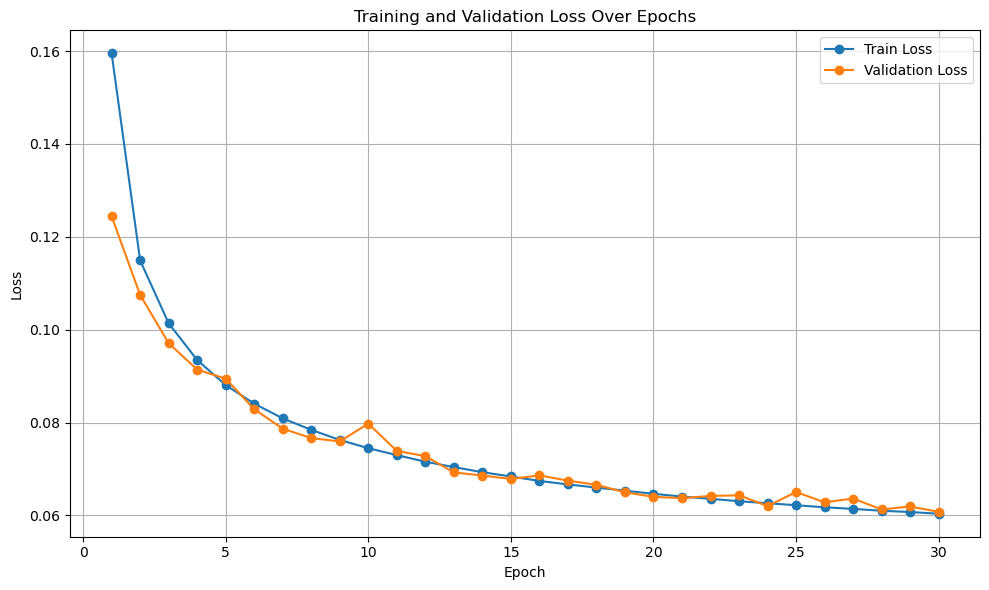

In [45]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


lire les images de le training up side

In [46]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

# # voltar para escala original das strains
# y_test_real = scaler_y.inverse_transform(y_test)
# y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# métricas globais
mae_global  = mean_absolute_error(y_test_real, y_pred_real)
rmse_global = mean_squared_error(y_test_real, y_pred_real, squared=False)
r2_global   = r2_score(y_test_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 24.5095
RMSE : 39.3704
R²   : 0.9392


In [47]:
metrics_per_flight = {}
unique_flights = np.unique(ids_test)

for flight in unique_flights:
    mask = (ids_test == flight)
    y_true_f = y_test_real[mask]
    y_pred_f = y_pred_real[mask]

    mae  = mean_absolute_error(y_true_f, y_pred_f)
    rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
    r2   = r2_score(y_true_f, y_pred_f)

    metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}

for flight, m in metrics_per_flight.items():
    print(f"{flight}: MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, R²={m['R2']:.4f}")

mae_mean  = np.mean([m["MAE"]  for m in metrics_per_flight.values()])
rmse_mean = np.mean([m["RMSE"] for m in metrics_per_flight.values()])
r2_mean   = np.mean([m["R2"]   for m in metrics_per_flight.values()])

print("\nAverage metrics across all TOLs (test):")
print(f"MAE médio  : {mae_mean:.4f}")
print(f"RMSE médio : {rmse_mean:.4f}")
print(f"R² médio   : {r2_mean:.4f}")

TOL_1: MAE=22.5762, RMSE=32.7546, R²=0.9428
TOL_10: MAE=21.9045, RMSE=33.0487, R²=0.9025
TOL_11: MAE=23.2656, RMSE=36.2651, R²=0.8990
TOL_12: MAE=30.6281, RMSE=50.3548, R²=0.8717
TOL_13: MAE=22.1869, RMSE=30.6279, R²=0.9354
TOL_14: MAE=30.3560, RMSE=47.8753, R²=0.9087
TOL_15: MAE=32.6397, RMSE=50.5265, R²=0.9030
TOL_17: MAE=24.1086, RMSE=34.0641, R²=0.9289
TOL_18: MAE=31.7119, RMSE=52.0625, R²=0.8700
TOL_19: MAE=26.7639, RMSE=44.0094, R²=0.8782
TOL_2: MAE=20.9361, RMSE=30.9102, R²=0.9115
TOL_20: MAE=30.8954, RMSE=47.1140, R²=0.8785
TOL_21: MAE=19.6110, RMSE=31.2110, R²=0.9501
TOL_22: MAE=16.6039, RMSE=23.3025, R²=0.8660
TOL_23: MAE=20.3956, RMSE=33.9720, R²=0.9010
TOL_24: MAE=20.8893, RMSE=30.7128, R²=0.9118
TOL_25: MAE=21.8045, RMSE=32.7425, R²=0.9386
TOL_26: MAE=29.3344, RMSE=49.9084, R²=0.9181
TOL_27: MAE=27.8354, RMSE=42.3315, R²=0.8159
TOL_28: MAE=28.8296, RMSE=44.4744, R²=0.8742
TOL_29: MAE=24.3227, RMSE=37.2435, R²=0.9039
TOL_3: MAE=17.7664, RMSE=25.2264, R²=0.9518
TOL_30: MAE=1

In [48]:
df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

# adicionar as métricas globais
df_global = pd.DataFrame({
    "MAE":  [mae_global],
    "RMSE": [rmse_global],
    "R2":   [r2_global]
}, index=["GLOBAL"])

# concatenar tudo
df_results = pd.concat([df_flights, df_global])



In [49]:
df_results.to_csv('df_results_filtered.csv')

In [51]:
df_results = pd.read_csv('df_results_filtered.csv')
df_results


,Unnamed: 0,MAE,RMSE,R2
0,TOL_1,22.576155,32.754566,0.942787
1,TOL_10,21.904549,33.048749,0.902506
2,TOL_11,23.265623,36.265050,0.898960
3,TOL_12,30.628112,50.354825,0.871734
4,TOL_13,22.186878,30.627908,0.935444
5,TOL_14,30.355974,47.875284,0.908706
6,TOL_15,32.639711,50.526451,0.903018
7,TOL_17,24.108641,34.064135,0.928856
8,TOL_18,31.711929,52.062550,0.870014
9,TOL_19,26.763921,44.009385,0.878163
